In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('cleaned_data.csv')
df = df.drop(columns=['Unnamed: 0'])
df.head(10)

,source,review_description,rating,review_date
0,Google Play,thread meta fantastic app staying connected cl...,5,2024-01-03 10:16:17
1,Google Play,nothing scammer trust,1,2024-01-01 13:36:11
2,Google Play,awesome,5,2023-12-17 22:40:19
3,Google Play,nice app,3,2023-12-14 01:49:26
4,Google Play,great alternative twitter x,5,2023-12-08 19:32:42
5,Google Play,soild,5,2023-12-08 19:14:14
6,Google Play,really good,5,2023-12-08 18:56:58
7,Google Play,excellent,5,2023-12-08 18:28:56
8,Google Play,social medium platform rife bot cat-fish type ...,1,2023-12-08 17:56:30
9,Google Play,freedom,1,2023-12-08 17:54:12


In [3]:
import nltk
nltk.download('stopwords')
nltk.download('worldnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading worldnet: Package 'worldnet' not found in
[nltk_data]     index
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeLL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
import nltk
from nltk.tokenize import word_tokenize

In [5]:
df['tokenized_reviews'] = df['review_description'].apply(lambda x: word_tokenize(str(x).lower()))
df['tokenized_reviews'].head()

0    [thread, meta, fantastic, app, staying, connec...
1                            [nothing, scammer, trust]
2                                            [awesome]
3                                          [nice, app]
4                     [great, alternative, twitter, x]
Name: tokenized_reviews, dtype: object

In [6]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df['clean_reviews'] = df['tokenized_reviews'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
df['clean_reviews'].head()

0    [thread, meta, fantastic, app, staying, connec...
1                            [nothing, scammer, trust]
2                                            [awesome]
3                                          [nice, app]
4                     [great, alternative, twitter, x]
Name: clean_reviews, dtype: object

In [7]:
features_keywords = [
    'ad-free', 'private account', 'private profile', 'privacy', 'post length', 'video',
    'timeline', 'post creation', 'messaging', 'media sharing', 'notifications',
    'dms', 'customization', 'hashtags', 'trending topics', 'search',
    'accessibility', 'privacy', 'performance',
]

def count_feature_mentions(review_tokens):
    count_dict = {feature: 0 for feature in features_keywords}
    for token in review_tokens:
        for feature in features_keywords:
            if feature in token:
                count_dict[feature] += 1
    return count_dict

df['feature_mentions_count'] = df['clean_reviews'].apply(count_feature_mentions)

total_feature_mentions = {}

# Iterate through each row and aggregate feature mentions
for index, row in df.iterrows():
    feature_counts = row['feature_mentions_count']
    for feature, count in feature_counts.items():
        total_feature_mentions[feature] = total_feature_mentions.get(feature, 0) + count

total_feature_mentions

{'ad-free': 2,
 'private account': 0,
 'private profile': 0,
 'privacy': 466,
 'post length': 0,
 'video': 644,
 'timeline': 259,
 'post creation': 0,
 'messaging': 93,
 'media sharing': 0,
 'notifications': 1,
 'dms': 5,
 'customization': 15,
 'hashtags': 391,
 'trending topics': 0,
 'search': 605,
 'accessibility': 9,
 'performance': 43}

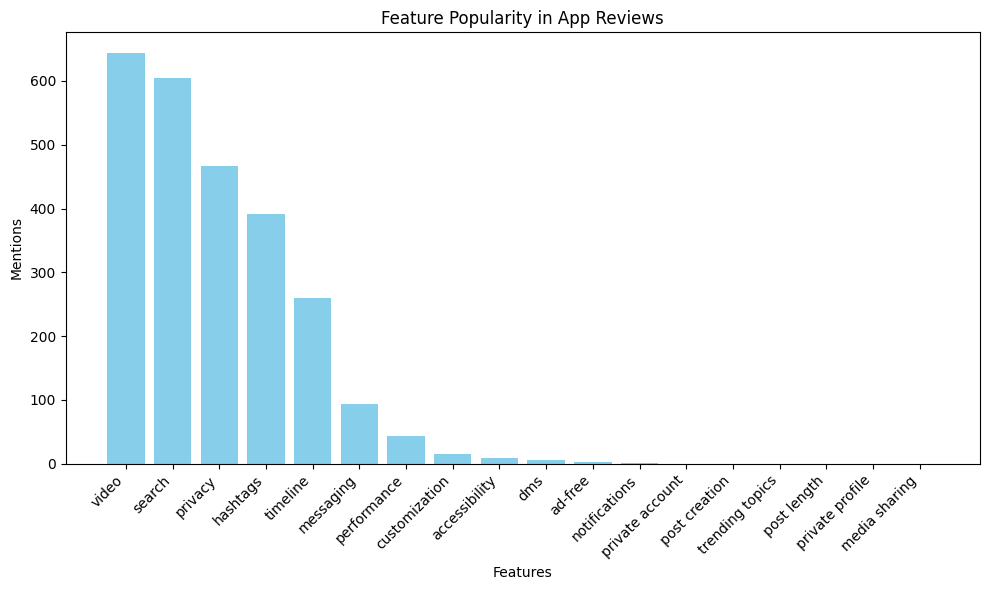

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
df_feature_mentions = pd.DataFrame(list(total_feature_mentions.items()), columns=['Feature', 'Mentions'])

df_feature_mentions = df_feature_mentions.sort_values(by='Mentions', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(df_feature_mentions['Feature'], df_feature_mentions['Mentions'], color='skyblue')
plt.xlabel('Features')
plt.ylabel('Mentions')
plt.title('Feature Popularity in App Reviews')
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for better readability
plt.tight_layout()
plt.show()

https://www.kaggle.com/code/leodoldan/customer-review-analysis-threads-app

In this notebook I'll analyze Thread's ratings on both iOS and Android and then try to answer the following question:

- What features of Threads users love the most?
- What features cause the most controversy?

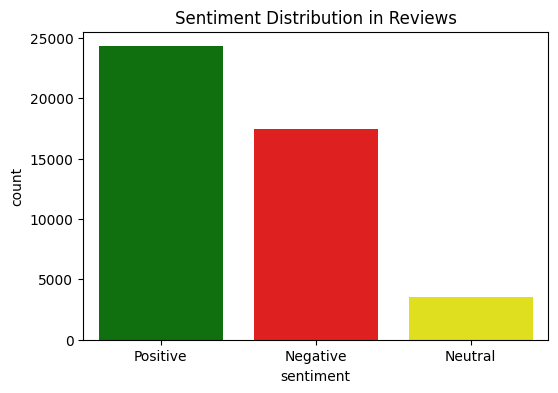

In [11]:
import seaborn as sns

# Function to label sentiment based on rating
def label_sentiment(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Apply the labeling function to create a new 'sentiment' column
df['sentiment'] = df['rating'].apply(label_sentiment)

# Set color palette for Positive (green), Neutral (yellow), Negative (red)
colors = {'Positive': 'green', 'Neutral': 'yellow', 'Negative': 'red'}

# Use seaborn to plot the sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=df, palette=colors)
plt.title('Sentiment Distribution in Reviews')
plt.show()


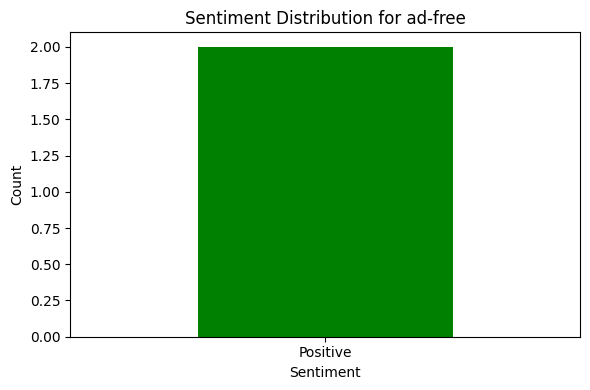

No sentiment data available for private account
No sentiment data available for private profile


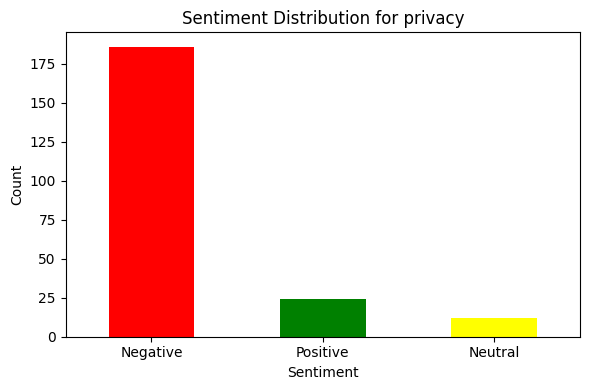

No sentiment data available for post length


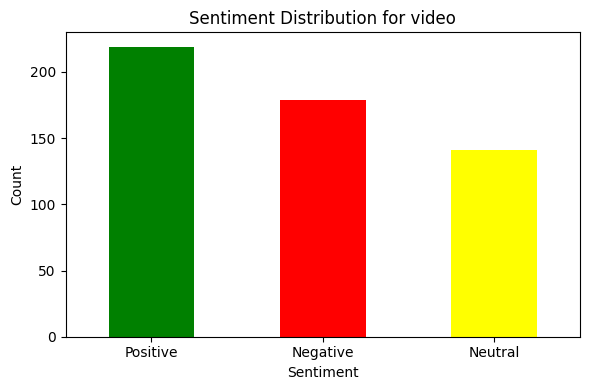

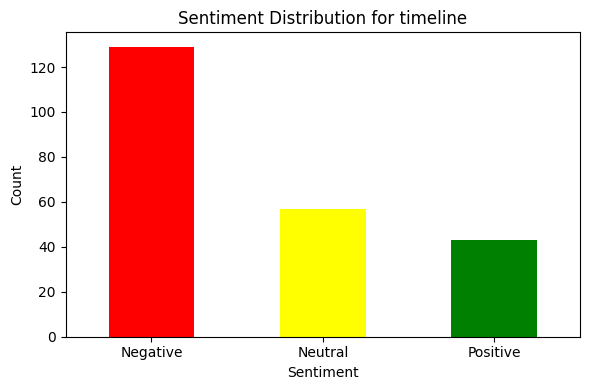

No sentiment data available for post creation


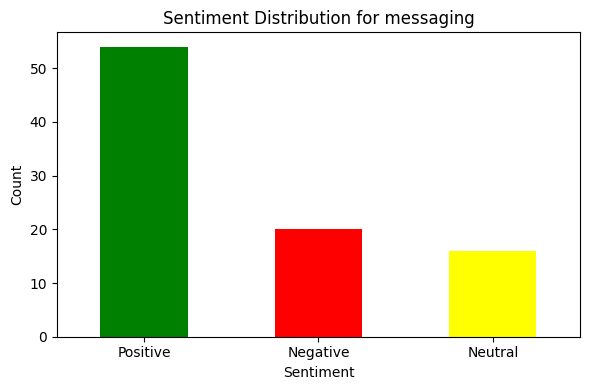

No sentiment data available for media sharing


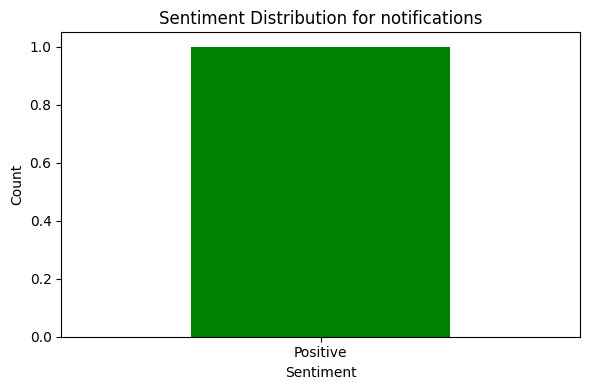

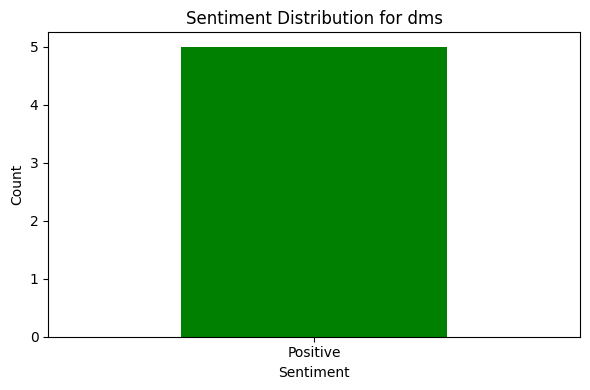

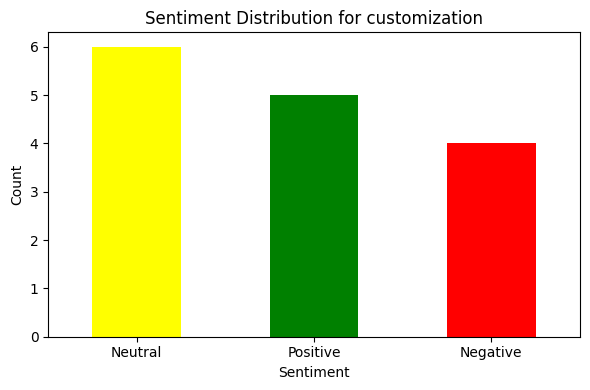

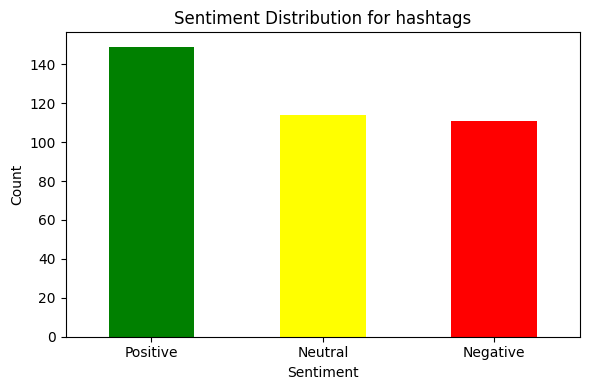

No sentiment data available for trending topics


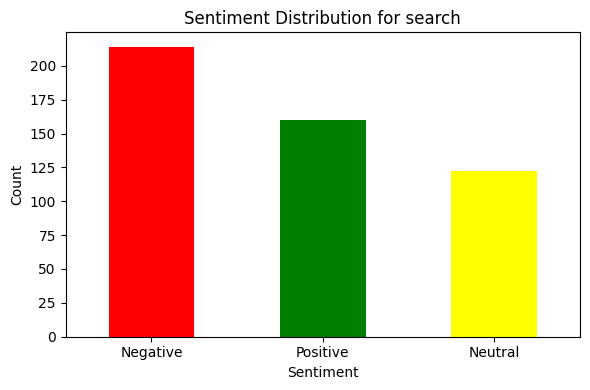

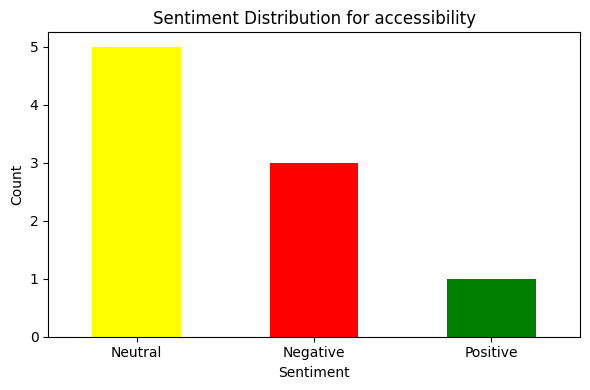

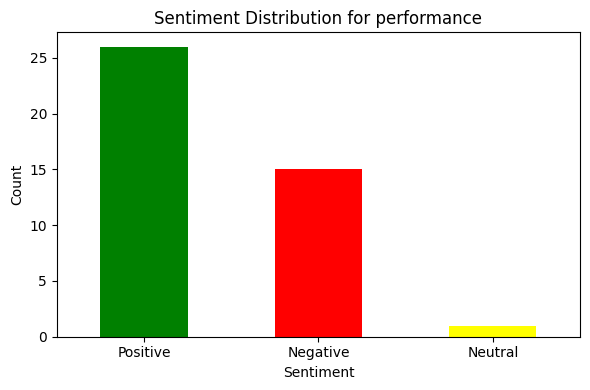

In [10]:
# Sentiment Distribution by Features

feature_sentiment_counts = {}
for feature in features_keywords:
    feature_sentiment_counts[feature] = df.apply(lambda row: row['sentiment'] if row['feature_mentions_count'].get(feature, 0) > 0 else None, axis=1).value_counts()

for feature, sentiment_counts in feature_sentiment_counts.items():
    if sentiment_counts.empty:
        print(f"No sentiment data available for {feature}")
    else:
        plt.figure(figsize=(6, 4))
        colors = ['green' if sentiment == 'Positive' else 'yellow' if sentiment == 'Neutral' else 'red' for sentiment in sentiment_counts.index]
        sentiment_counts.plot(kind='bar', color=colors)
        plt.title(f'Sentiment Distribution for {feature}')
        plt.xlabel('Sentiment')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.show()
